<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pre-trained AlexNet to train and classifier leishmanioses and pyoderma images

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [3]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

## Data Transformation

In [4]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [5]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [7]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 1
Imagem 1, Label: 1
Imagem 2, Label: 0
Imagem 3, Label: 0
Imagem 4, Label: 0
Imagem 5, Label: 1
Imagem 6, Label: 0
Imagem 7, Label: 1


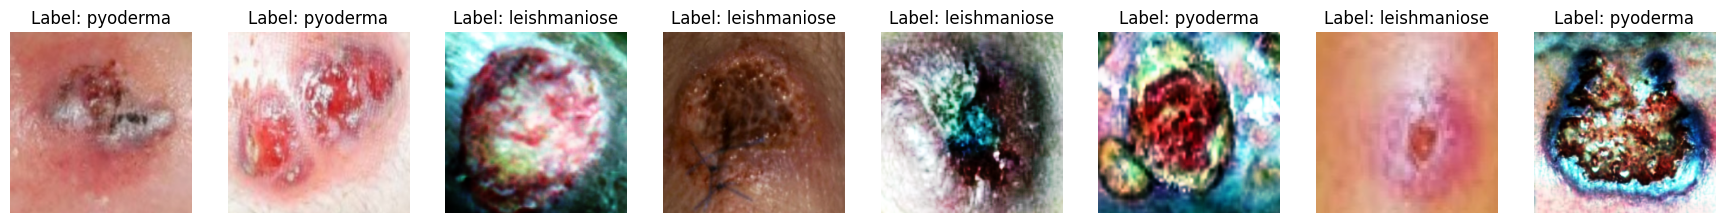

In [8]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo
    ax = axes[i]
    ax.set_title(f"Label: {'leishmaniose' if label_value == 0 else 'pyoderma'}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [9]:
train_loader.dataset.classes

['leishmaniose', 'pyoderma']

In [10]:
test_loader.dataset.classes

['leishmaniose', 'pyoderma']

In [11]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 51


In [12]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 16


In [13]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'leishmaniose': 0, 'pyoderma': 1}


In [14]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'leishmaniose': 0, 'pyoderma': 1}


## Model Train

In [15]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 146MB/s]


In [16]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [18]:
num_classes

2

In [19]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [20]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [23]:
!pip install torchsummary

In [24]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [26]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=7d30a4074f0a25849fc990bbe0bfe9275dabf1d37147c36276aa17f37c8be4d6
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [27]:
from torchviz import make_dot

In [28]:
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Exemplo de entrada
y = model(sample_input)  # Passando o input pelo modelo
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.6804
Epoch [2/10], Loss: 0.6225
Epoch [3/10], Loss: 0.3413
Epoch [4/10], Loss: 0.3106
Epoch [5/10], Loss: 0.3098
Epoch [6/10], Loss: 0.3284
Epoch [7/10], Loss: 0.2390
Epoch [8/10], Loss: 0.1042
Epoch [9/10], Loss: 0.2814
Epoch [10/10], Loss: 0.2189


Epoch [1/10], Loss: 0.7241
Epoch [2/10], Loss: 0.7609
Epoch [3/10], Loss: 0.5918
Epoch [4/10], Loss: 0.3808
Epoch [5/10], Loss: 0.3063
Epoch [6/10], Loss: 0.4957
Epoch [7/10], Loss: 0.3695
Epoch [8/10], Loss: 0.2651
Epoch [9/10], Loss: 0.1630
Epoch [10/10], Loss: 0.1553


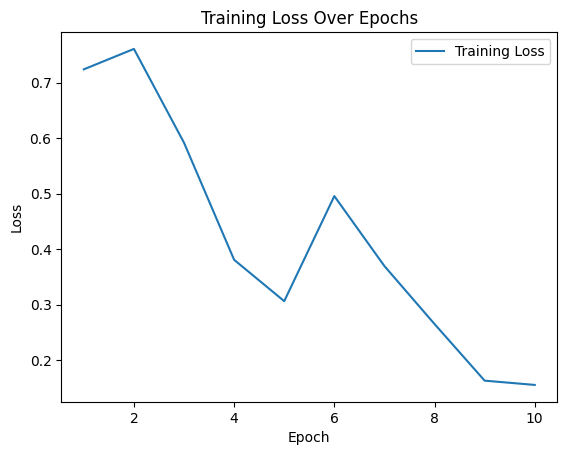

In [32]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Model Evatualion

In [ ]:
# Avaliação do modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Armazene os rótulos e as previsões
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Acurácia no conjunto de teste: {100 * correct / total:.2f}%')

Acurácia no conjunto de teste: 81.25%


In [ ]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



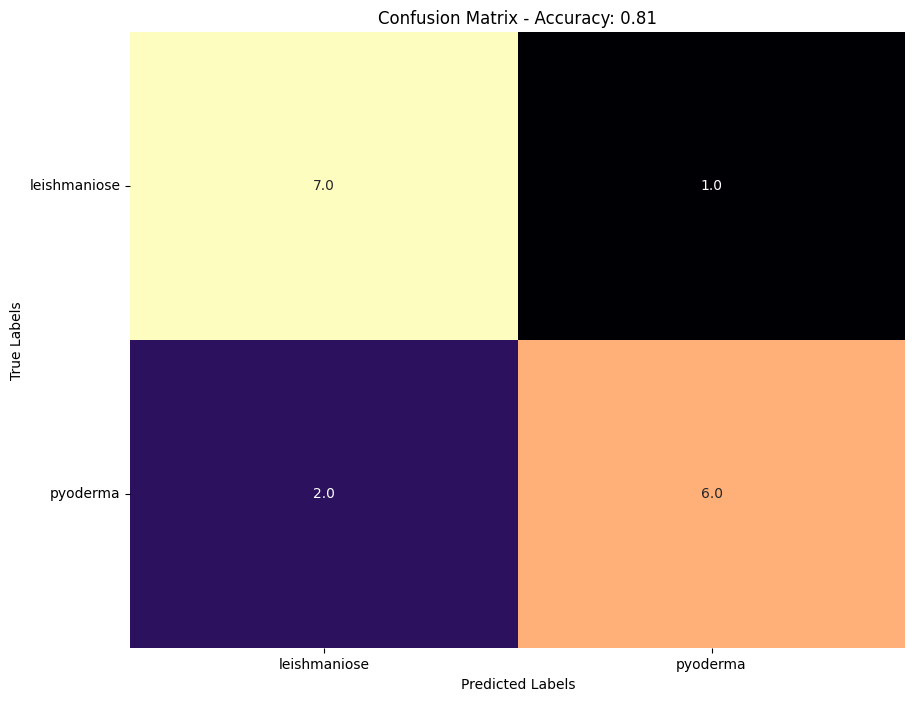

In [ ]:
# Criar a matriz de confusão
cm = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
ax.set_xticklabels(['leishmaniose', 'pyoderma',])
ax.set_yticklabels(['leishmaniose', 'pyoderma'], rotation=0)
plt.show()

## Model Deployment